### import

In [1]:
import os
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,confusion_matrix, precision_recall_fscore_support
import cv2
import dlib

## Imbalanced data

### data load & preprocessing

In [104]:
data_dir = './pca_data1/train' # csv 파일이 저장된 디렉토리의 경로

# 트레인 데이터 로드
train_data = []
train_labels = []

# 폴더 내의 이미지 데이터 가져오기
for folder_name in os.listdir(data_dir):
    folder_dir = os.path.join(data_dir, folder_name)
    if os.path.isdir(folder_dir):
        for filename in os.listdir(folder_dir):
            file_path = os.path.join(folder_dir, filename)
            if os.path.isfile(file_path):
                image = Image.open(file_path)
                # 이미지 데이터를 1차원 배열로 변환
                image_array = np.array(image).flatten()
                train_data.append(image_array)
                train_labels.append(os.path.basename(folder_dir))  # 파일 이름에서 라벨 추출

# 이미지 데이터를 numpy 배열로 변환
train_img = np.array(train_data)
print(train_img.shape)

(966, 1850)


In [7]:
# 테스트 데이터 경로
test_data_dir = './pca_data1/test'

# 테스트 데이터 로드
test_data = []
test_labels = []

# 폴더 내의 이미지 데이터 가져오기
for folder_name in os.listdir(test_data_dir):
    folder_dir = os.path.join(test_data_dir, folder_name)
    if os.path.isdir(folder_dir):
        for filename in os.listdir(folder_dir):
            file_path = os.path.join(folder_dir, filename)
            if os.path.isfile(file_path):
                image = Image.open(file_path)
                # 이미지 데이터를 1차원 배열로 변환
                image_array = np.array(image).flatten()
                test_data.append(image_array)
                test_labels.append(os.path.basename(folder_dir))  # 파일 이름에서 라벨 추출

# 이미지 데이터를 numpy 배열로 변환
test_img = np.array(test_data)
print(test_img.shape)

(322, 1850)


### EDA

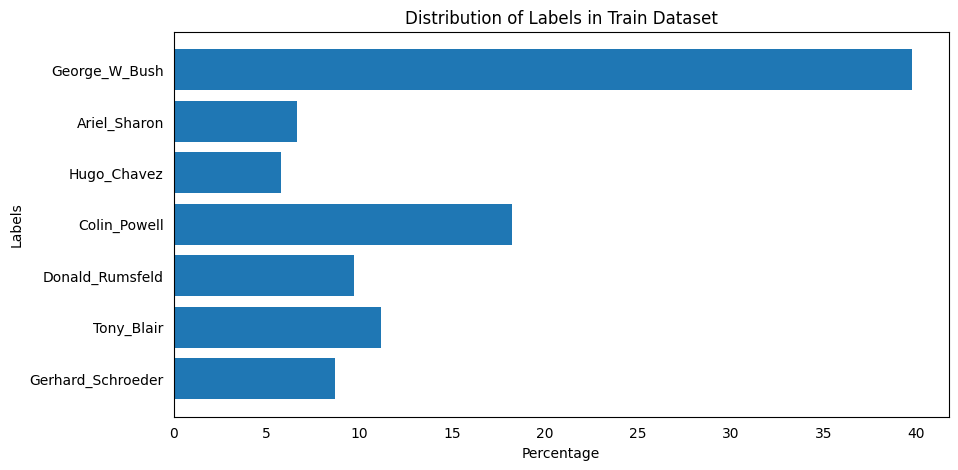

In [100]:
# train labels로 데이터 경향성 분석
from collections import Counter

label_counts = Counter(train_labels)
total_count = len(train_labels)

label_percentages = {}
for label, count in label_counts.items():
    label_percentages[label] = (count / total_count) * 100

labels = list(label_percentages.keys())
percentages = list(label_percentages.values())

fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(labels, percentages)

plt.title('Distribution of Labels in Train Dataset')
plt.xlabel('Percentage')
plt.ylabel('Labels')

ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

plt.show()

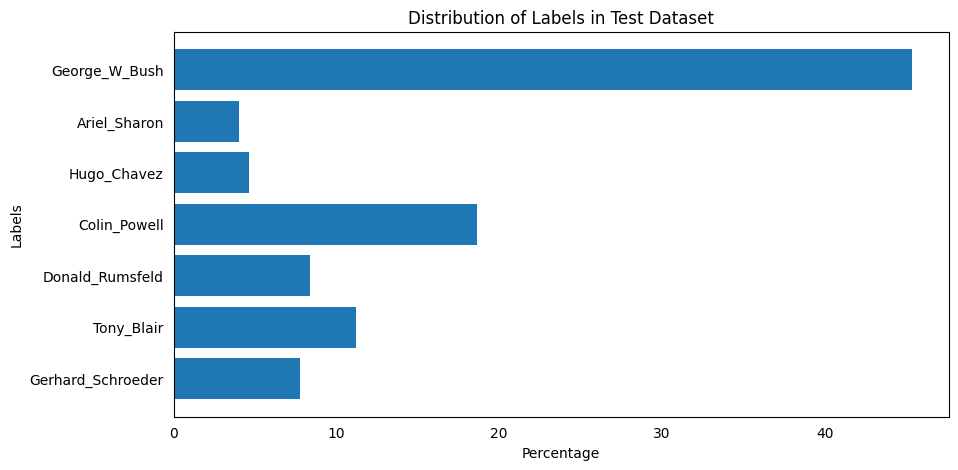

In [101]:
# test labels로 데이터 경향성 분석
from collections import Counter

label_counts = Counter(test_labels)
total_count = len(test_labels)

label_percentages = {}
for label, count in label_counts.items():
    label_percentages[label] = (count / total_count) * 100

labels = list(label_percentages.keys())
percentages = list(label_percentages.values())

fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(labels, percentages)

plt.title('Distribution of Labels in Test Dataset')
plt.xlabel('Percentage')
plt.ylabel('Labels')

ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

plt.show()

### pca

In [106]:
# train 데이터를 PCA를 사용하여 차원 축소
pca = PCA(n_components=128)
train_img_pca = pca.fit_transform(train_img)

# 결과 확인
print('train image shape: ',train_img_pca.shape)

train image shape:  (966, 128)


In [93]:
# PCA 차원 비교

# 64차원 PCA
pca64 = PCA(n_components=64)
img_data_pca64 = pca64.fit_transform(train_img)

# 128차원 PCA
pca128 = PCA(n_components=128)
img_data_pca64 = pca128.fit_transform(train_img)

# 256차원 PCA
pca256 = PCA(n_components=256)
img_data_pca64 = pca256.fit_transform(train_img)

# 설명률 출력
print("64차원 PCA 설명률:", sum(pca64.explained_variance_ratio_))
print("128차원 PCA 설명률:", sum(pca128.explained_variance_ratio_))
print("256차원 PCA 설명률:", sum(pca256.explained_variance_ratio_))


64차원 PCA 설명률: 0.8883843685411413
128차원 PCA 설명률: 0.9465014588222176
256차원 PCA 설명률: 0.9823239900941254


선택한 차원 수: 135


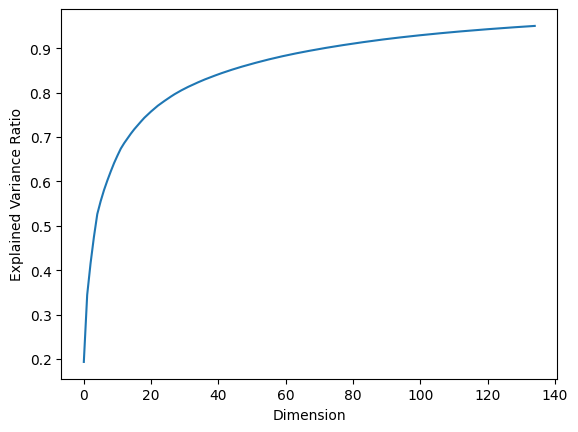

In [91]:
# PCA를 사용하여 차원 축소
pca = PCA(n_components=0.95) # 95% 이상의 설명률을 보이는 차원을 선택
train_img_pca = pca.fit_transform(train_img)

# 설명률 계산
var_ratio_cumsum = np.cumsum(pca.explained_variance_ratio_)
print('선택한 차원 수:', np.argmax(var_ratio_cumsum >= 0.95) + 1) # 차원 수 출력

# 설명률 그래프 그리기
plt.plot(var_ratio_cumsum)
plt.xlabel('Dimension')
plt.ylabel('Explained Variance Ratio')
plt.show()

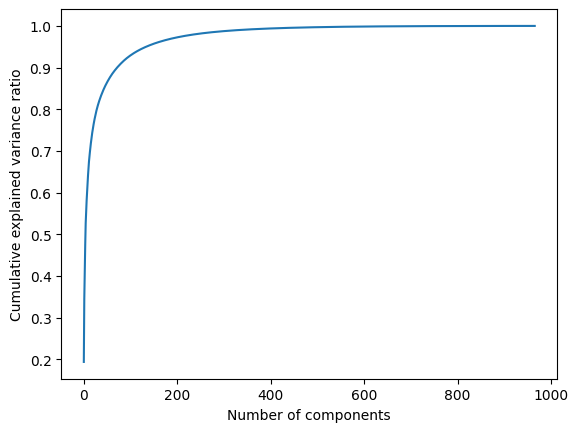

In [90]:
# PCA 객체 생성
pca = PCA()

# train_img를 PCA를 이용하여 128차원까지 축소
pca.fit(train_img)
cumulative_var_ratio = np.cumsum(pca.explained_variance_ratio_)

# 그래프 그리기
plt.plot(cumulative_var_ratio)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance ratio')
plt.show()

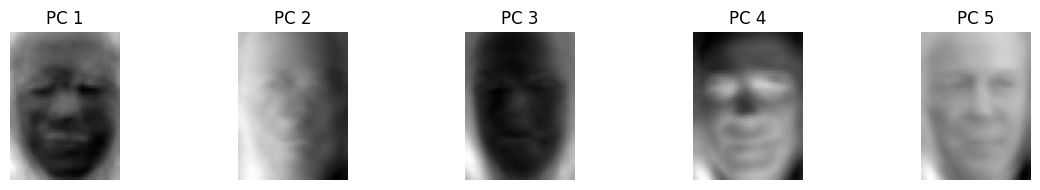

In [10]:
# 주성분 상위 5개 eigenvector 가져오기
eigenvectors = pca.components_[:5]

# 주성분 eigenvector 시각화
fig, axes = plt.subplots(1, 5, figsize=(12, 2))

for i, eigenvector in enumerate(eigenvectors):
    # 주성분 eigenvector를 이미지로 변환
    eigenvector_image = eigenvector.reshape(50, 37)
    
    # 이미지를 0-255 범위로 조정
    eigenvector_image = (eigenvector_image - np.min(eigenvector_image)) / (
        np.max(eigenvector_image) - np.min(eigenvector_image)
    )
    eigenvector_image = (eigenvector_image * 255).astype(np.uint8)
    
    # 이미지를 흑백으로 표시
    axes[i].imshow(eigenvector_image, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'PC {i+1}')

plt.tight_layout()
plt.show()

In [8]:
# test 데이터를 PCA를 사용하여 차원 축소
test_img_pca = pca.fit_transform(test_img)
print('test image shape: ',test_img_pca.shape)

test image shape:  (322, 128)


### prediction with L2 distance

In [116]:
# 예측된 라벨을 저장할 리스트
predicted_labels = []

# L2 distance를 계산하여 가장 가까운 훈련 데이터의 라벨을 예측값으로 지정합니다.
for test_image in test_img_pca:
    distances = np.sqrt(np.sum((train_img_pca - test_image)**2, axis=1))
    closest_idx = np.argmin(distances)
    predicted_label = train_labels[closest_idx]
    predicted_labels.append(predicted_label)

# 테스트 데이터와 예측된 훈련 데이터의 라벨을 함께 출력합니다.
for i, test_label in enumerate(test_labels):
    print("Test label: {} Predicted label: {}".format(test_label, predicted_labels[i]))

Test label: Gerhard_Schroeder Predicted label: George_W_Bush
Test label: Gerhard_Schroeder Predicted label: George_W_Bush
Test label: Gerhard_Schroeder Predicted label: Donald_Rumsfeld
Test label: Gerhard_Schroeder Predicted label: George_W_Bush
Test label: Gerhard_Schroeder Predicted label: Tony_Blair
Test label: Gerhard_Schroeder Predicted label: George_W_Bush
Test label: Gerhard_Schroeder Predicted label: George_W_Bush
Test label: Gerhard_Schroeder Predicted label: George_W_Bush
Test label: Gerhard_Schroeder Predicted label: Donald_Rumsfeld
Test label: Gerhard_Schroeder Predicted label: George_W_Bush
Test label: Gerhard_Schroeder Predicted label: George_W_Bush
Test label: Gerhard_Schroeder Predicted label: Tony_Blair
Test label: Gerhard_Schroeder Predicted label: George_W_Bush
Test label: Gerhard_Schroeder Predicted label: Colin_Powell
Test label: Gerhard_Schroeder Predicted label: George_W_Bush
Test label: Gerhard_Schroeder Predicted label: Colin_Powell
Test label: Gerhard_Schroede

Precision:  [ 0.     23.7288  5.2632 46.3576  4.7619  0.     11.4286]
Macro Precision:  13.0772
Micro Precision:  28.2609
Recall:  [ 0.     23.3333  7.4074 47.9452  4.      0.     11.1111]
Macro Recall:  13.3996
Micro Recall:  28.2609
Accuracy:  28.2609 %


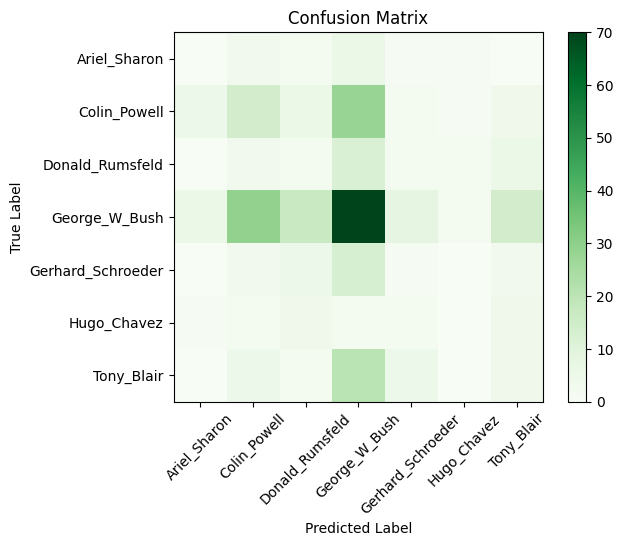

In [117]:
# confusion matrix를 계산합니다.
cm = confusion_matrix(test_labels, predicted_labels)

# confusion matrix를 시각화합니다.
plt.imshow(cm, cmap="Greens")
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(np.unique(test_labels)))
plt.xticks(tick_marks, np.unique(test_labels), rotation=45)
plt.yticks(tick_marks, np.unique(test_labels))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# precision, recall, accuracy를 계산합니다.
precision, recall, _, _ = precision_recall_fscore_support(test_labels, predicted_labels, average=None)
# Macro 방식으로 전체 label의 precision과 recall을 계산합니다.
macro_precision, macro_recall, _, _ = precision_recall_fscore_support(test_labels, predicted_labels, average='macro')
# Micro 방식으로 전체 label의 precision과 recall을 계산합니다.
micro_precision, micro_recall, _, _ = precision_recall_fscore_support(test_labels, predicted_labels, average='micro')

# precision, recall, accuracy를 백분율로 출력합니다.
print("Precision: ", (precision * 100).round(4))
print("Macro Precision: ", (macro_precision * 100).round(4))
print("Micro Precision: ", (micro_precision * 100).round(4))


print("Recall: ", (recall * 100).round(4))
print("Macro Recall: ", (macro_recall * 100).round(4))
print("Micro Recall: ", (micro_recall * 100).round(4))

accuracy = accuracy_score(test_labels, predicted_labels)
print("Accuracy: ", (accuracy * 100).round(4), "%")

plt.show()

### prediction with SVM

In [79]:
from sklearn import svm

# SVM 모델 인스턴스 생성
clf = svm.SVC()
# train 데이터 학습
clf.fit(train_img_pca, train_labels)
# test 데이터 예측
predicted_labels = clf.predict(test_img_pca)

# 테스트 데이터와 예측된 훈련 데이터의 라벨을 함께 출력합니다.
for i, test_label in enumerate(test_labels):
    print("Test label: {} Predicted label: {}".format(test_label, predicted_labels[i]))

Test label: Gerhard_Schroeder Predicted label: George_W_Bush
Test label: Gerhard_Schroeder Predicted label: George_W_Bush
Test label: Gerhard_Schroeder Predicted label: George_W_Bush
Test label: Gerhard_Schroeder Predicted label: Gerhard_Schroeder
Test label: Gerhard_Schroeder Predicted label: George_W_Bush
Test label: Gerhard_Schroeder Predicted label: George_W_Bush
Test label: Gerhard_Schroeder Predicted label: George_W_Bush
Test label: Gerhard_Schroeder Predicted label: Ariel_Sharon
Test label: Gerhard_Schroeder Predicted label: George_W_Bush
Test label: Gerhard_Schroeder Predicted label: George_W_Bush
Test label: Gerhard_Schroeder Predicted label: George_W_Bush
Test label: Gerhard_Schroeder Predicted label: George_W_Bush
Test label: Gerhard_Schroeder Predicted label: George_W_Bush
Test label: Gerhard_Schroeder Predicted label: Donald_Rumsfeld
Test label: Gerhard_Schroeder Predicted label: George_W_Bush
Test label: Gerhard_Schroeder Predicted label: George_W_Bush
Test label: Gerhard

Precision:  [ 0.     29.0909  0.     42.7907 11.1111  0.      5.8824]
Recall:  [ 0.     26.6667  0.     63.0137  4.      0.      2.7778]
Accuracy:  34.1615 %


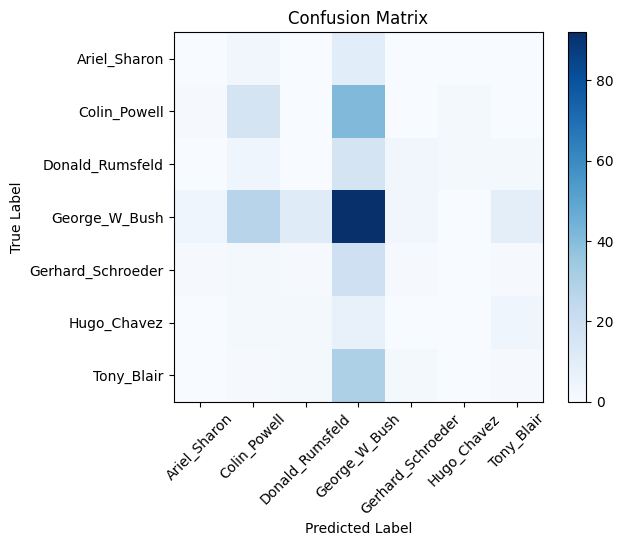

In [80]:
# confusion matrix를 계산합니다.
cm = confusion_matrix(test_labels, predicted_labels)

# confusion matrix를 시각화합니다.
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(np.unique(test_labels)))
plt.xticks(tick_marks, np.unique(test_labels), rotation=45)
plt.yticks(tick_marks, np.unique(test_labels))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# precision, recall, accuracy를 계산합니다.
precision, recall, f1_score, support = precision_recall_fscore_support(test_labels, predicted_labels, average=None)
accuracy = accuracy_score(test_labels, predicted_labels)

# precision, recall, accuracy를 백분율로 출력합니다.
print("Precision: ", (precision * 100).round(4))
print("Recall: ", (recall * 100).round(4))
print("Accuracy: ", (accuracy * 100).round(4), "%")

plt.show()

### prediction with Random Forest

In [129]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Create a random forest classifier with 100 trees
rfc = RandomForestClassifier(n_estimators=100)

# Train the model on the training data
rfc.fit(train_img_pca, train_labels)

# Make predictions on the test data
predicted_labels = rfc.predict(test_img_pca)

# 테스트 데이터와 예측된 훈련 데이터의 라벨을 함께 출력합니다.
for i, test_label in enumerate(test_labels):
    print("Test label: {} Predicted label: {}".format(test_label, predicted_labels[i]))

Test label: Gerhard_Schroeder Predicted label: George_W_Bush
Test label: Gerhard_Schroeder Predicted label: George_W_Bush
Test label: Gerhard_Schroeder Predicted label: George_W_Bush
Test label: Gerhard_Schroeder Predicted label: Colin_Powell
Test label: Gerhard_Schroeder Predicted label: George_W_Bush
Test label: Gerhard_Schroeder Predicted label: George_W_Bush
Test label: Gerhard_Schroeder Predicted label: George_W_Bush
Test label: Gerhard_Schroeder Predicted label: George_W_Bush
Test label: Gerhard_Schroeder Predicted label: George_W_Bush
Test label: Gerhard_Schroeder Predicted label: George_W_Bush
Test label: Gerhard_Schroeder Predicted label: George_W_Bush
Test label: Gerhard_Schroeder Predicted label: George_W_Bush
Test label: Gerhard_Schroeder Predicted label: George_W_Bush
Test label: Gerhard_Schroeder Predicted label: George_W_Bush
Test label: Gerhard_Schroeder Predicted label: George_W_Bush
Test label: Gerhard_Schroeder Predicted label: George_W_Bush
Test label: Gerhard_Schro

Precision:  [ 0.     10.3448  0.     45.1957  0.      0.      0.    ]
Macro Precision:  7.9344
Micro Precision:  40.3727
Recall:  [ 0.      5.      0.     86.9863  0.      0.      0.    ]
Macro Recall:  13.1409
Micro Recall:  40.3727
Accuracy:  40.3727 %


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


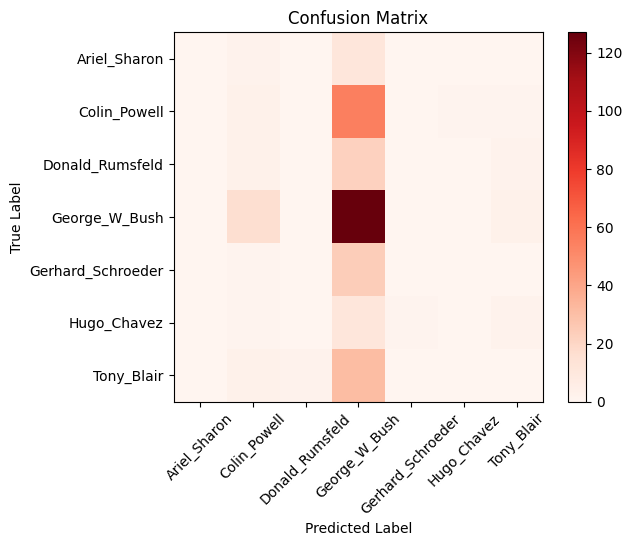

In [130]:
# confusion matrix를 계산합니다.
cm = confusion_matrix(test_labels, predicted_labels)

# confusion matrix를 시각화합니다.
plt.imshow(cm, cmap="Reds")
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(np.unique(test_labels)))
plt.xticks(tick_marks, np.unique(test_labels), rotation=45)
plt.yticks(tick_marks, np.unique(test_labels))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# precision, recall, accuracy를 계산합니다.
precision, recall, _, _ = precision_recall_fscore_support(test_labels, predicted_labels, average=None)
# Macro 방식으로 전체 label의 precision과 recall을 계산합니다.
macro_precision, macro_recall, _, _ = precision_recall_fscore_support(test_labels, predicted_labels, average='macro')
# Micro 방식으로 전체 label의 precision과 recall을 계산합니다.
micro_precision, micro_recall, _, _ = precision_recall_fscore_support(test_labels, predicted_labels, average='micro')

# precision, recall, accuracy를 백분율로 출력합니다.
print("Precision: ", (precision * 100).round(4))
print("Macro Precision: ", (macro_precision * 100).round(4))
print("Micro Precision: ", (micro_precision * 100).round(4))


print("Recall: ", (recall * 100).round(4))
print("Macro Recall: ", (macro_recall * 100).round(4))
print("Micro Recall: ", (micro_recall * 100).round(4))

accuracy = accuracy_score(test_labels, predicted_labels)
print("Accuracy: ", (accuracy * 100).round(4), "%")

plt.show()

### George_W_Bush 의 데이터로 01

In [131]:
# George_W_Bush 를 기준으로 라벨을 0 또는 1로 변환
train_labels_binary = np.asarray([1 if label == "George_W_Bush" else 0 for label in train_labels])
test_labels_binary = np.asarray([1 if label == "George_W_Bush" else 0 for label in test_labels])
pred_labels_binary = np.asarray([1 if label == "George_W_Bush" else 0 for label in predicted_labels])

# FRR: George_W_Bush 인데 George_W_Bush 가 아니라고 예측한 비율
frr = 1 - np.mean(pred_labels_binary[test_labels_binary == 1])

# FAR: George_W_Bush 가 아닌데 George_W_Bush 로 예측한 비율
far = np.mean(pred_labels_binary[test_labels_binary == 0])

# CER: 전체 중에서 예측이 틀린 비율
cer = (np.sum(np.abs(test_labels_binary - pred_labels_binary)) / len(test_labels_binary))

# 결과 출력
print("False Rejection Rate (FRR):", frr)
print("False Acceptance Rate (FAR):", far)
print("Classification Error Rate (CER):", cer)

False Rejection Rate (FRR): 0.13013698630136983
False Acceptance Rate (FAR): 0.875
Classification Error Rate (CER): 0.5372670807453416


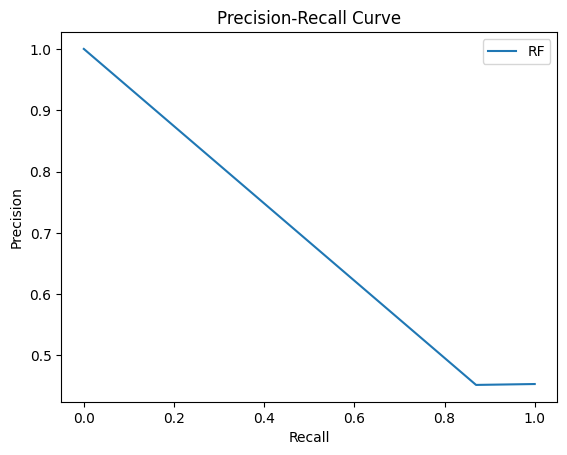

In [133]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# 예측 결과와 실제 라벨 비교하여 precision, recall, threshold 계산
precision, recall, thresholds = precision_recall_curve(test_labels_binary, pred_labels_binary)

# precision-recall 그래프 출력
plt.plot(recall, precision, label='RF')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

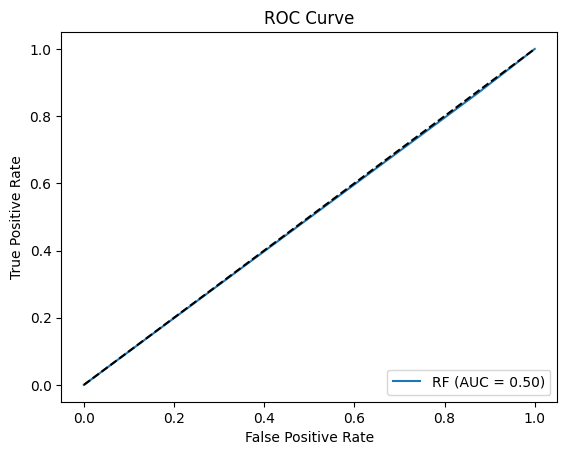

In [134]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 예측 결과와 실제 라벨 비교하여 fpr, tpr, threshold 계산
fpr, tpr, thresholds = roc_curve(test_labels_binary, pred_labels_binary)
roc_auc = auc(fpr, tpr)

# roc curve 그래프 출력
plt.plot(fpr, tpr, label='RF (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

## Balanced data

### preprocessing

In [2]:
data_dir = './pca_data1/train'

train_data_s = []
train_labels_s = []

for folder_name in os.listdir(data_dir):
    folder_dir = os.path.join(data_dir, folder_name)
    if os.path.isdir(folder_dir):
        count = 0  # 이미지 파일 수 카운터 초기화
        for filename in os.listdir(folder_dir):
            if count >= 94:  # 이미지 파일 수가 138개 이상이면 루프 종료
                break
            file_path = os.path.join(folder_dir, filename)
            if os.path.isfile(file_path):
                image = Image.open(file_path)
                image_array = np.array(image).flatten()
                train_data_s.append(image_array)
                train_labels_s.append(os.path.basename(folder_dir))
                count += 1  # 이미지 파일 수 증가

# 이미지 데이터를 numpy 배열로 변환
train_img_s = np.array(train_data_s)
print(train_img_s.shape)

# 테스트 데이터 경로
test_data_dir = './pca_data1/test'

# 테스트 데이터 로드
test_data = []
test_labels = []

# 폴더 내의 이미지 데이터 가져오기
for folder_name in os.listdir(test_data_dir):
    folder_dir = os.path.join(test_data_dir, folder_name)
    if os.path.isdir(folder_dir):
        for filename in os.listdir(folder_dir):
            file_path = os.path.join(folder_dir, filename)
            if os.path.isfile(file_path):
                image = Image.open(file_path)
                # 이미지 데이터를 1차원 배열로 변환
                image_array = np.array(image).flatten()
                test_data.append(image_array)
                test_labels.append(os.path.basename(folder_dir))  # 파일 이름에서 라벨 추출

# 이미지 데이터를 numpy 배열로 변환
test_img = np.array(test_data)
print(test_img.shape)

(580, 1850)
(322, 1850)


In [3]:
# train, test 데이터를 PCA를 사용하여 차원 축소
pca = PCA(n_components=128)
train_img_pca_s = pca.fit_transform(train_img_s)

# 결과 확인
print('train image shape: ',train_img_pca_s.shape)

train image shape:  (580, 128)


In [6]:
test_img_pca = pca.fit_transform(test_img)
print('test image shape: ',test_img_pca.shape)

test image shape:  (322, 128)


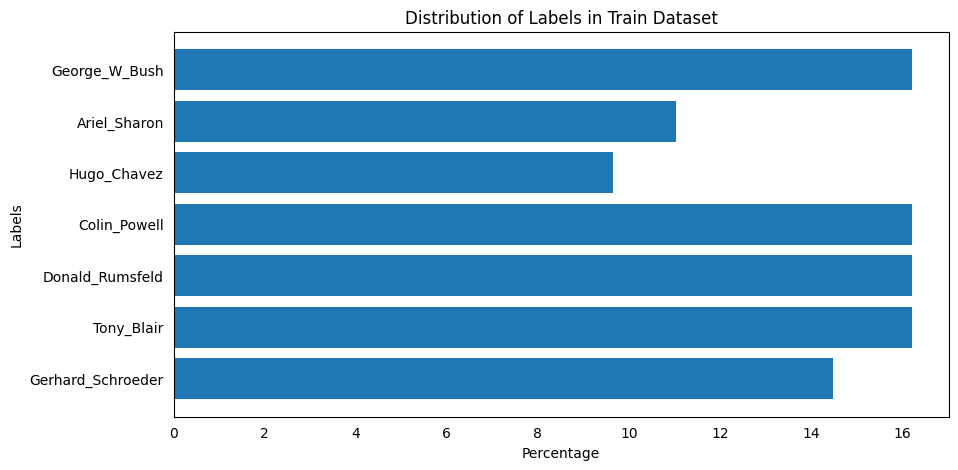

In [4]:
# train labels로 데이터 경향성 분석
from collections import Counter

label_counts = Counter(train_labels_s)
total_count = len(train_labels_s)

label_percentages = {}
for label, count in label_counts.items():
    label_percentages[label] = (count / total_count) * 100

labels = list(label_percentages.keys())
percentages = list(label_percentages.values())

fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(labels, percentages)

plt.title('Distribution of Labels in Train Dataset')
plt.xlabel('Percentage')
plt.ylabel('Labels')

ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

plt.show()

### prediction with L2 distance

In [7]:
# 예측된 라벨을 저장할 리스트
predicted_labels = []

# L2 distance를 계산하여 가장 가까운 훈련 데이터의 라벨을 예측값으로 지정합니다.
for test_image in test_img_pca:
    distances = np.sqrt(np.sum((train_img_pca_s - test_image)**2, axis=1))
    closest_idx = np.argmin(distances)
    predicted_label = train_labels_s[closest_idx]
    predicted_labels.append(predicted_label)

# 테스트 데이터와 예측된 훈련 데이터의 라벨을 함께 출력합니다.
for i, test_label in enumerate(test_labels):
    print("Test label: {} Predicted label: {}".format(test_label, predicted_labels[i]))

Test label: Gerhard_Schroeder Predicted label: Donald_Rumsfeld
Test label: Gerhard_Schroeder Predicted label: Donald_Rumsfeld
Test label: Gerhard_Schroeder Predicted label: Colin_Powell
Test label: Gerhard_Schroeder Predicted label: Colin_Powell
Test label: Gerhard_Schroeder Predicted label: Donald_Rumsfeld
Test label: Gerhard_Schroeder Predicted label: Gerhard_Schroeder
Test label: Gerhard_Schroeder Predicted label: Donald_Rumsfeld
Test label: Gerhard_Schroeder Predicted label: Colin_Powell
Test label: Gerhard_Schroeder Predicted label: Colin_Powell
Test label: Gerhard_Schroeder Predicted label: Colin_Powell
Test label: Gerhard_Schroeder Predicted label: Gerhard_Schroeder
Test label: Gerhard_Schroeder Predicted label: Colin_Powell
Test label: Gerhard_Schroeder Predicted label: Gerhard_Schroeder
Test label: Gerhard_Schroeder Predicted label: Hugo_Chavez
Test label: Gerhard_Schroeder Predicted label: Hugo_Chavez
Test label: Gerhard_Schroeder Predicted label: Colin_Powell
Test label: Ger

Precision:  [ 8.5714 18.6441  7.5758 40.4762 15.625  14.8148 11.4754]
Macro Precision:  16.7404
Micro Precision:  16.1491
Recall:  [23.0769 18.3333 18.5185 11.6438 20.     26.6667 19.4444]
Macro Recall:  19.6691
Micro Recall:  16.1491
Accuracy:  16.1491 %


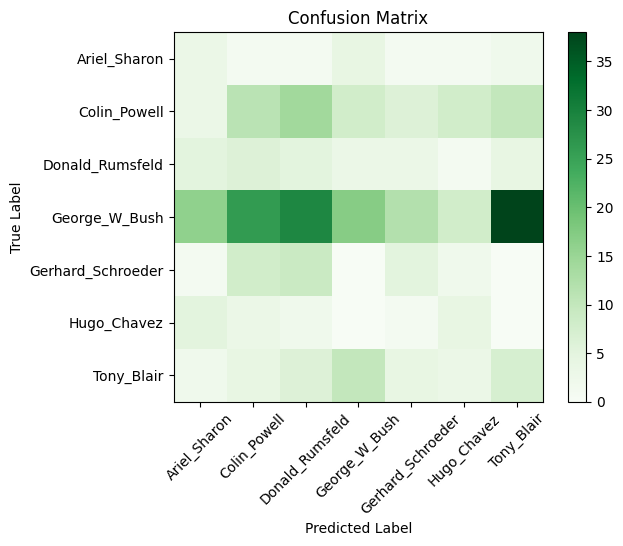

In [8]:
# confusion matrix를 계산합니다.
cm = confusion_matrix(test_labels, predicted_labels)

# confusion matrix를 시각화합니다.
plt.imshow(cm, cmap="Greens")
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(np.unique(test_labels)))
plt.xticks(tick_marks, np.unique(test_labels), rotation=45)
plt.yticks(tick_marks, np.unique(test_labels))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# precision, recall, accuracy를 계산합니다.
precision, recall, _, _ = precision_recall_fscore_support(test_labels, predicted_labels, average=None)
# Macro 방식으로 전체 label의 precision과 recall을 계산합니다.
macro_precision, macro_recall, _, _ = precision_recall_fscore_support(test_labels, predicted_labels, average='macro')
# Micro 방식으로 전체 label의 precision과 recall을 계산합니다.
micro_precision, micro_recall, _, _ = precision_recall_fscore_support(test_labels, predicted_labels, average='micro')

# precision, recall, accuracy를 백분율로 출력합니다.
print("Precision: ", (precision * 100).round(4))
print("Macro Precision: ", (macro_precision * 100).round(4))
print("Micro Precision: ", (micro_precision * 100).round(4))


print("Recall: ", (recall * 100).round(4))
print("Macro Recall: ", (macro_recall * 100).round(4))
print("Micro Recall: ", (micro_recall * 100).round(4))

accuracy = accuracy_score(test_labels, predicted_labels)
print("Accuracy: ", (accuracy * 100).round(4), "%")

plt.show()

### prediction with Random Forest

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Create a random forest classifier with 100 trees
rfc = RandomForestClassifier(n_estimators=100)

# Train the model on the training data
rfc.fit(train_img_pca_s, train_labels_s)

# Make predictions on the test data
predicted_labels = rfc.predict(test_img_pca)

# 테스트 데이터와 예측된 훈련 데이터의 라벨을 함께 출력합니다.
for i, test_label in enumerate(test_labels):
    print("Test label: {} Predicted label: {}".format(test_label, predicted_labels[i]))

Test label: Gerhard_Schroeder Predicted label: George_W_Bush
Test label: Gerhard_Schroeder Predicted label: Colin_Powell
Test label: Gerhard_Schroeder Predicted label: Gerhard_Schroeder
Test label: Gerhard_Schroeder Predicted label: Tony_Blair
Test label: Gerhard_Schroeder Predicted label: Gerhard_Schroeder
Test label: Gerhard_Schroeder Predicted label: Colin_Powell
Test label: Gerhard_Schroeder Predicted label: George_W_Bush
Test label: Gerhard_Schroeder Predicted label: Tony_Blair
Test label: Gerhard_Schroeder Predicted label: George_W_Bush
Test label: Gerhard_Schroeder Predicted label: George_W_Bush
Test label: Gerhard_Schroeder Predicted label: Donald_Rumsfeld
Test label: Gerhard_Schroeder Predicted label: Gerhard_Schroeder
Test label: Gerhard_Schroeder Predicted label: Colin_Powell
Test label: Gerhard_Schroeder Predicted label: Colin_Powell
Test label: Gerhard_Schroeder Predicted label: Gerhard_Schroeder
Test label: Gerhard_Schroeder Predicted label: Gerhard_Schroeder
Test label: 

Precision:  [11.1111  7.9365  5.1282 39.4366 22.5806  0.      8.9552]
Macro Precision:  13.5926
Micro Precision:  15.8385
Recall:  [ 7.6923  8.3333 14.8148 19.1781 28.      0.     16.6667]
Macro Recall:  13.5265
Micro Recall:  15.8385
Accuracy:  15.8385 %


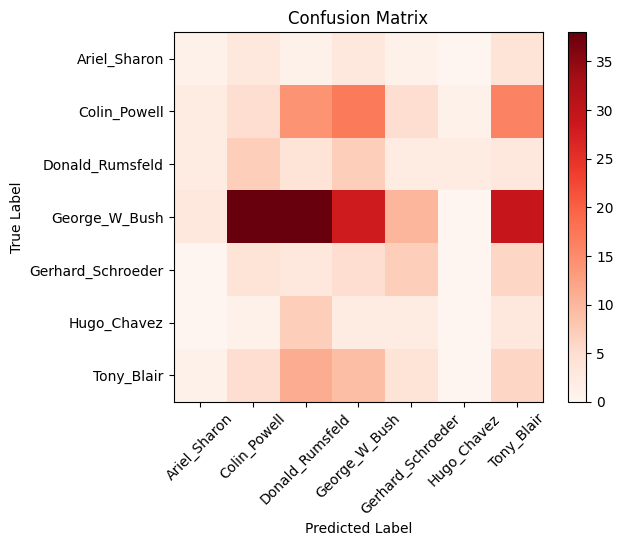

In [10]:
# confusion matrix를 계산합니다.
cm = confusion_matrix(test_labels, predicted_labels)

# confusion matrix를 시각화합니다.
plt.imshow(cm, cmap="Reds")
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(np.unique(test_labels)))
plt.xticks(tick_marks, np.unique(test_labels), rotation=45)
plt.yticks(tick_marks, np.unique(test_labels))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# precision, recall, accuracy를 계산합니다.
precision, recall, _, _ = precision_recall_fscore_support(test_labels, predicted_labels, average=None)
# Macro 방식으로 전체 label의 precision과 recall을 계산합니다.
macro_precision, macro_recall, _, _ = precision_recall_fscore_support(test_labels, predicted_labels, average='macro')
# Micro 방식으로 전체 label의 precision과 recall을 계산합니다.
micro_precision, micro_recall, _, _ = precision_recall_fscore_support(test_labels, predicted_labels, average='micro')

# precision, recall, accuracy를 백분율로 출력합니다.
print("Precision: ", (precision * 100).round(4))
print("Macro Precision: ", (macro_precision * 100).round(4))
print("Micro Precision: ", (micro_precision * 100).round(4))


print("Recall: ", (recall * 100).round(4))
print("Macro Recall: ", (macro_recall * 100).round(4))
print("Micro Recall: ", (micro_recall * 100).round(4))

accuracy = accuracy_score(test_labels, predicted_labels)
print("Accuracy: ", (accuracy * 100).round(4), "%")

plt.show()

## My Face

(50, 37)


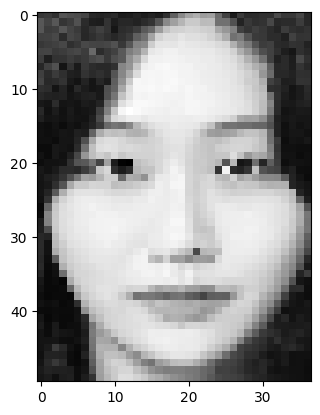

In [79]:
# 이미지 파일 로드
image = cv2.imread('./pca_data1/myface/my_pic.png')

# 자른 얼굴 이미지 보여주기
cv2.imshow('Face Image', image)
plt.imshow(image)

# 얼굴 영역 검출기 생성
detector = dlib.get_frontal_face_detector()

# 이미지에서 얼굴 영역 검출
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
faces = detector(gray)

# 각 얼굴 영역에 대해서 반복적으로 처리
for face in faces:
    x, y, w, h = face.left(), face.top(), face.width(), face.height()
    face_image = image[y-160:y+h+40, x-10:x+w+10]
    image_c = cv2.resize(face_image, (37,50)) # reshape
    image_c = cv2.cvtColor(image_c, cv2.COLOR_BGR2GRAY)
    cv2.imwrite('./pca_data1/myface/my_pic_crop.png', image_c)
    # 자른 얼굴 이미지 보여주기
plt.imshow(image_c, cmap='gray')
print(image_c.shape)

In [90]:
from sklearn.metrics.pairwise import pairwise_distances

# image_c PCA 변환
image_c_pca = pca.transform(image_c.reshape(1, -1))

# L2 distance 계산
distances = np.linalg.norm(train_img_pca_s - image_c_pca, axis=1)

# 가장 가까운 이미지의 인덱스 찾기
closest_idx = np.argmin(distances)

# 가장 가까운 이미지의 라벨 출력
closest_label = train_labels_s[closest_idx]
print(f"The closest image label is {closest_label}")


The closest image label is George_W_Bush


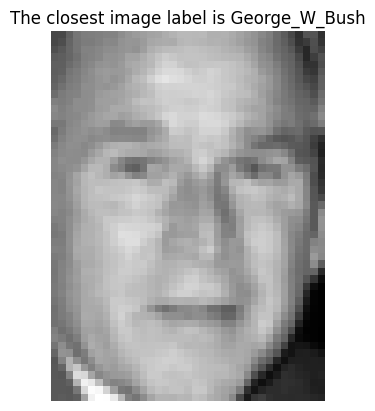

In [93]:
# 가장 가까운 이미지 출력
closest_image = train_img_s[closest_idx].reshape(50, 37)
plt.imshow(closest_image, cmap="gray")
plt.axis("off")
plt.title(f"The closest image label is {closest_label}")
plt.show()

### im not George_w_Bush

In [95]:
# 가장 가까운 이미지와의 L2 distance 출력
closest_distance = distances[closest_idx]
print(f"The closest distance is {closest_distance:.2f}")

The closest distance is 2310.02
